# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder, StandardScaler

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV

from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from sklearn.metrics import mean_squared_error

In [2]:
try:
    autos = pd.read_csv('/datasets/autos.csv') 
except:
    autos = pd.read_csv('/datasets/autos.csv')

In [3]:
display(autos.head(5))
print('-----------------------------------------------------------------')

display(autos.info())
print('-----------------------------------------------------------------')

display(autos.describe())
print('-----------------------------------------------------------------')

print('Кол-во пропусков:')
display(autos.isna().sum())
print('-----------------------------------------------------------------')

print('Кол-во дубликатов -', autos.duplicated().sum())

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


-----------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  La

None

-----------------------------------------------------------------


,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


-----------------------------------------------------------------
Кол-во пропусков:


DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

-----------------------------------------------------------------
Кол-во дубликатов - 4


**Вывод:**

1. Замечено наличие признаков, не влияющих на цену - DateCrawel, RegistrationMonth, DateCreated, NumberOfPictures, PostalCode и LastSeen - от них можно избавиться;
2. В признаках имеются пропуски;
3. В целевом признаке и признаке Power есть 0 - возможно есть и другие выбросы;
4. В RegistrationYear указан минимальный год 1000 - возможно есть и другие выбросы; 
5. Замечено наличие дубликатов, от которых нужно избавиться;
6. Скорректировать названия признаков;
7. В признаках Gearbox и NotRepaired значения можно заменить на 1|0.

## Предобработка данных

In [4]:
#Преобразования названий в змеиный стиль:
autos.columns = autos.columns.str.replace(r"([A-Z])", r" \1").str.lower().str.replace(' ', '_').str[1:]
autos.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

In [5]:
#Избавление от дубликатов:
autos.drop_duplicates(inplace=True)

In [6]:
#Избавление от признаков, не влияющих на целевой признак:
autos.drop(columns=['date_crawled', 'date_created', 'number_of_pictures',
                    'postal_code', 'last_seen', 'registration_month'],
           axis=1,
           inplace=True)

### Целевой признак price

In [7]:
#Смотрим, сколько нулей в целевом признаке:
autos.price.value_counts()

0        10772
500       5670
1500      5394
1000      4648
1200      4594
         ...  
13180        1
10879        1
2683         1
634          1
8188         1
Name: price, Length: 3731, dtype: int64

In [8]:
#Удаляем все 0 из целевого признака:
autos = autos.query('price > 0')

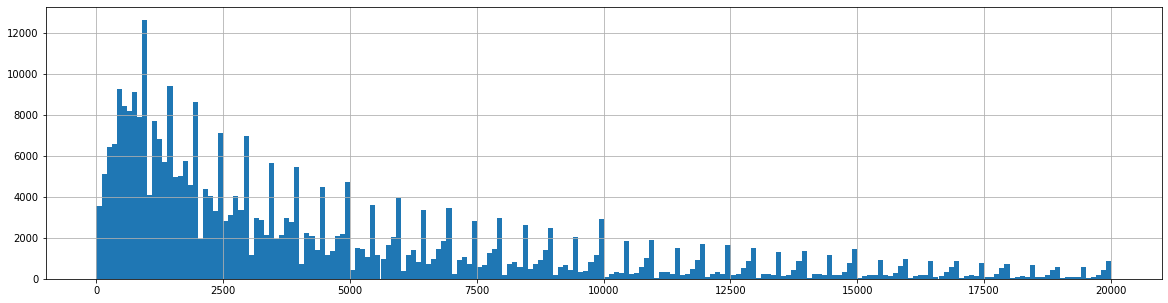

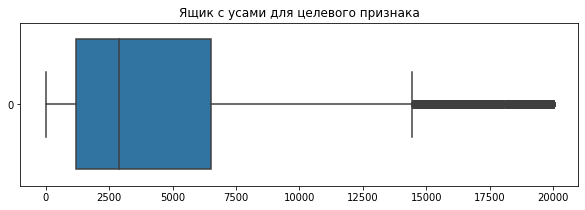

In [9]:
#Строим гистограмму и ящик с усами для целевого признака: 
autos.price.hist(bins=200, figsize=(20,5))

plt.figure(figsize=(10,3))
sns.boxplot(data=autos.price, orient='h')
plt.title('Ящик с усами для целевого признака')
plt.show()

In [10]:
#Так как на гистограмме и ящике с усами странные данные у нуля и длинный хвост возле 15000, смотрю квантили:
autos.price.quantile([.05, 0.95])

0.05      350.0
0.95    14800.0
Name: price, dtype: float64

In [11]:
#Проверка доли строк, где цена меньше 350 и больше 14800:
1 - autos.query('350 <= price <= 14800').shape[0] / autos.shape[0]

0.09517365021988222

In [12]:
#Отсечение 10% строк, где цена меньше 350 и больше 14800:
autos = autos.query('350 <= price <= 14800')

### Признак registrationyear

In [13]:
#Просмотр значений в registration_year:
autos.registration_year.value_counts()

2000    20907
2005    20811
1999    20621
2003    19217
2001    19091
        ...  
1948        1
1949        1
5300        1
8888        1
2290        1
Name: registration_year, Length: 130, dtype: int64

In [14]:
annual = autos.pivot_table(index='registration_year', values='brand', aggfunc='count')
annual.columns = ['quantity']
annual

,quantity
registration_year,
1000,18
1001,1
1039,1
1111,1
1234,2
...,...
8500,1
8888,1
9000,2


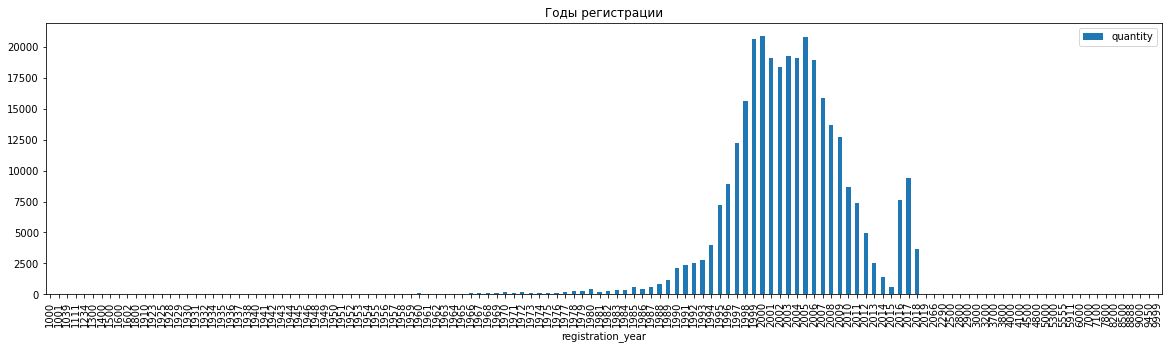

In [15]:
#Строим график для registrationyear: 
annual.plot.bar(figsize = (20,5))
plt.title('Годы регистрации')
plt.show()

In [16]:
#Рассмотрим самый поздний год выгрузки:
autos_ = pd.read_csv('/datasets/autos.csv')
autos_.DateCrawled.max()

'2016-04-07 14:36:58'

In [17]:
#вряд ли авто ранее 1975 и позже 2016 (органичение данных) были поставлены на учет и на продажу
#поэтому оставляю в таблице только годы регистрации с 1975 по 2016:
autos = autos.query('1975 <= registration_year <= 2016')

### Признак power

In [18]:
#Просмотр значений в power:
autos.power.value_counts()

0        26795
75       20640
60       13045
150      13008
101      12106
         ...  
1082         1
1079         1
1703         1
2729         1
17019        1
Name: power, Length: 627, dtype: int64

<AxesSubplot:>

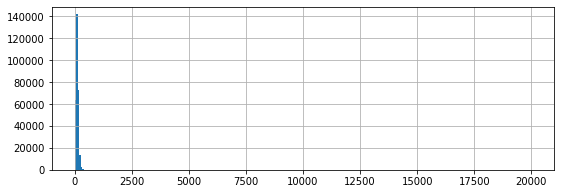

In [19]:
#Построение гистограммы power:
autos.power.hist(bins=300, figsize=(9,3))

In [20]:
autos.power.describe()

count    296131.000000
mean        111.028275
std         184.505329
min           0.000000
25%          75.000000
50%         105.000000
75%         140.000000
max       20000.000000
Name: power, dtype: float64

In [21]:
#поскольку самое мощное по состоянию на 2022 год легковое авто имеет 1600лс,
#а самое слабое из представленных брендов авто - Citroen 2CV - имеет 9лс,  
#то выкину из таблицы всё, что выше и ниже этих границ:
autos = autos.query('9 <= power <= 1600')

### Признак kilometer

In [22]:
#Просмотр значений в kilometer:
autos.kilometer.value_counts()

150000    183628
125000     29148
100000     11366
90000       9039
80000       7752
70000       6539
60000       5584
50000       4453
40000       3436
30000       2906
20000       2331
5000        2250
10000        580
Name: kilometer, dtype: int64

В признаке kilometer выбросов нет и аномалий нет

### Признак brand

In [23]:
autos.brand.value_counts()

volkswagen        58354
opel              29855
bmw               28889
mercedes_benz     24458
audi              22560
ford              18500
renault           12928
peugeot            8945
fiat               7018
seat               5413
skoda              4583
smart              4449
mazda              4446
citroen            4007
toyota             3855
nissan             3602
hyundai            2887
volvo              2564
mini               2491
mitsubishi         2286
honda              2270
kia                1912
suzuki             1848
alfa_romeo         1846
chevrolet          1347
sonstige_autos     1225
chrysler           1093
dacia               785
subaru              571
daihatsu            557
jeep                494
saab                444
porsche             390
jaguar              372
daewoo              366
land_rover          362
lancia              340
rover               327
trabant             222
lada                151
Name: brand, dtype: int64

В признаке brand неявных дубликатов нет

### Признак gearbox

In [24]:
#Замена NaN на 'manual':
autos.fillna({'gearbox':'manual'}, inplace=True)

In [25]:
#Замена в gearbox значение manual на 1, auto - на 0:
autos.loc[(autos.gearbox == 'manual'), 'gearbox'] = 1   
autos.loc[(autos.gearbox == 'auto'), 'gearbox'] = 0

In [26]:
autos.gearbox = autos.gearbox.astype('int')

### Признак repaired

In [27]:
#Замена NaN на 'yes', так как обычно любая подержанная машина была в ремонте:
autos.fillna({'repaired':'yes'}, inplace=True)

In [28]:
#заменяю в notrepaired значение yes на 1, no - на 0:
autos.loc[(autos.repaired == 'yes'), 'repaired'] = 1
autos.loc[(autos.repaired == 'no'), 'repaired'] = 0

In [29]:
autos.repaired = autos.repaired.astype('int')

### Признак model

In [30]:
#Замена NaN на 'unknown':
autos.fillna({'model':'unknown'}, inplace=True)
autos.model.value_counts()

golf                  22613
other                 17963
3er                   16108
polo                   9730
unknown                9544
                      ...  
gl                        2
range_rover_evoque        2
serie_2                   2
serie_3                   1
rangerover                1
Name: model, Length: 250, dtype: int64

### Признак vehicletype

In [31]:
#Замена пропусков на unknown:
autos.fillna({'vehicle_type':'unknown'}, inplace=True)
autos.vehicle_type.value_counts()

sedan          76356
small          64638
wagon          54746
bus            24453
convertible    16423
coupe          12311
unknown         9206
suv             8687
other           2192
Name: vehicle_type, dtype: int64

### Признак fueltype

In [32]:
autos.fillna({'fuel_type':'unknown'}, inplace=True)
autos.fuel_type.value_counts()

petrol      171651
gasoline     78636
unknown      13456
lpg           4527
cng            467
hybrid         154
other           66
electric        55
Name: fuel_type, dtype: int64

In [33]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 269012 entries, 2 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              269012 non-null  int64 
 1   vehicle_type       269012 non-null  object
 2   registration_year  269012 non-null  int64 
 3   gearbox            269012 non-null  int64 
 4   power              269012 non-null  int64 
 5   model              269012 non-null  object
 6   kilometer          269012 non-null  int64 
 7   fuel_type          269012 non-null  object
 8   brand              269012 non-null  object
 9   repaired           269012 non-null  int64 
dtypes: int64(6), object(4)
memory usage: 22.6+ MB


In [34]:
autos.corr()['price']

price                1.000000
registration_year    0.530652
gearbox             -0.212265
power                0.406937
kilometer           -0.338210
repaired            -0.233246
Name: price, dtype: float64

**Вывод:**

1. Изменено/Удалено: 
    - Признаки, которые не влияют на целевой признак
    - Верблюжий стиль в названиях
    - Дубликаты
    - Выбросы в целевом признаке и признаках
    
    
2. Заполнены пропуски:
    - gearbox значением 'manual', и заменила значения на 1|0
    - notrepaired значением 'yes', и заменила значения на 1|0
    - model, vehicletype, fueltype значением 'unknown'
    
  
3. Цена зависит от: 
    - Прямо пропорционально от года регистрации, мощности
    - Обратно пропорционально от пробега, ремонта, типа коробки
    
В результате обработки данных датафрейм сократился на 21%, однако данных (278 837 строк) достаточно для обучения моделей.

## Обучение моделей

In [35]:
#Выдляем признаки и целевой признак:
features_orig = autos.drop('price', axis=1)
target = autos.price

In [36]:
#Разделение на выборки:
features_train, features_test, target_train, target_test = train_test_split(features_orig,
                                                                            target, 
                                                                            test_size=.25,
                                                                            random_state=12345)

In [37]:
# прямое кодирование (для линейных моделей)
features_train_ohe = pd.get_dummies(features_train, drop_first=True)
features_test_ohe = pd.get_dummies(features_test, drop_first=True)
# после прямого кодирования кол-во признаков в выборках будет отличаться
# поэтому стоит удалить лишние признаки в каждой выборке

# Найдем общие признаки между обучающей, валидационной и тестовой выборками
common_columns = set(features_train_ohe.columns) & set(features_test_ohe.columns)

# Оставим в каждой выборке только общие признаки
features_train_ohe = features_train_ohe[list(common_columns)]
features_test_ohe = features_test_ohe[list(common_columns)]

In [38]:
# порядковое кодирование (для "деревянных моделей")
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=9999)
cat_columns = autos.select_dtypes(include=['object']).columns
encoder.fit(features_train[cat_columns])

features_train_oe = features_train.copy()
features_test_oe = features_test.copy()

features_train_oe[cat_columns] = encoder.transform(features_train_oe[cat_columns])
features_test_oe[cat_columns] = encoder.transform(features_test_oe[cat_columns])

#Кодировка признаки через OE:
encoder = OrdinalEncoder()

features_train_oe = features_train[['vehicle_type','fuel_type','brand','model']]
features_train_oe = pd.DataFrame(encoder.fit_transform(features_train),
                                 columns=features_train.columns,
                                 index=features_train.index)

target_train_oe = target_train.copy()

In [39]:
#Размеры выборок:
for i in [features_train_ohe, features_test_ohe, target_train_ohe, target_test_ohe]:
    print(i.shape)    
    
print()

for i in [features_train_oe, features_test_oe, target_train_oe, target_test_oe]:
    print(i.shape)

print()
    
for i in [features_train, features_test, target_train, target_test]:
    print(i.shape)

(201759, 308)
(67253, 308)
(201759,)
(67253,)

(201759, 9)
(67253, 9)
(201759,)
(67253,)

(201759, 9)
(67253, 9)
(201759,)
(67253,)


### Модель LinearRegression

#### На выборках с OneHotEncoder

In [40]:
%%time

model_lr = LinearRegression()
model_lr.fit(features_train_ohe, target_train_ohe)

CPU times: user 11.6 s, sys: 5.43 s, total: 17 s
Wall time: 17 s


LinearRegression()

In [41]:
%%time

target_predict = model_lr.predict(features_train_ohe)

CPU times: user 369 ms, sys: 322 ms, total: 690 ms
Wall time: 697 ms


In [42]:
rmse_lr_ohe = mean_squared_error(target_train_ohe, target_predict) ** .5
rmse_lr_ohe

2072.53321718147

#### На выборках с OrdinalEncoder

In [43]:
%%time

model_lr = LinearRegression()
model_lr.fit(features_train_oe, target_train_oe)

CPU times: user 42.1 ms, sys: 20.6 ms, total: 62.7 ms
Wall time: 51.5 ms


LinearRegression()

In [44]:
%%time

target_predict = model_lr.predict(features_train_oe)

CPU times: user 14.8 ms, sys: 21.3 ms, total: 36.1 ms
Wall time: 39.7 ms


In [45]:
rmse_lr_oe = mean_squared_error(target_train_oe, target_predict) ** .5
rmse_lr_oe

2359.4990513276075

#### С использованием кроссвлидации

In [46]:
%%time

model_lr = LinearRegression()

#mse доступна только как neg_mean_squared_error, которая возвращает массив отрицательных значений
#поэтому на -1 умножаю:
cvs_rmse_lr = (cross_val_score(model_lr,
                               features_train_ohe,
                               target_train_ohe,
                               cv=5,
                               scoring='neg_mean_squared_error')).mean() * -1 ** .5
cvs_rmse_lr

CPU times: user 46.1 s, sys: 26.7 s, total: 1min 12s
Wall time: 1min 13s


4316599.289912512

In [47]:
%%time

model_lr = LinearRegression()

cvs_rmse_lr = (cross_val_score(model_lr,
                               features_train_oe,
                               target_train_oe,
                               cv=5,
                               scoring='neg_mean_squared_error')).mean() * -1 ** .5
cvs_rmse_lr

CPU times: user 413 ms, sys: 582 ms, total: 995 ms
Wall time: 999 ms


5567904.076855193

 ### Модель CatBoostRegression

#### На выборках c OneHotEncoder

In [48]:
%%time

model_cbr = CatBoostRegressor() 
parameters = [{'learning_rate':[.1, .5, .8], 'random_state':[12345], 'verbose':[False]}]

gscv = GridSearchCV(model_cbr, parameters, scoring='neg_mean_squared_error')
gscv.fit(features_train_ohe, target_train_ohe)

print(gscv.best_params_)

mts = gscv.cv_results_['mean_test_score']
    
gscv_rsme_cbr_ohe = (max(mts) * -1) ** .5
gscv_rsme_cbr_ohe

{'learning_rate': 0.5, 'random_state': 12345, 'verbose': False}
CPU times: user 5min 21s, sys: 3.59 s, total: 5min 24s
Wall time: 5min 44s


1305.3142292413966

In [49]:
%%time

model_cbr = CatBoostRegressor(learning_rate=.5, random_state=12345, verbose=False) #подставила лучшие параметры
model_cbr.fit(features_train_ohe, target_train_ohe)

CPU times: user 23.4 s, sys: 163 ms, total: 23.5 s
Wall time: 24.6 s


In [50]:
%%time

target_predict = model_cbr.predict(features_test_ohe)

CPU times: user 141 ms, sys: 180 µs, total: 141 ms
Wall time: 140 ms


In [51]:
rmse_cbr_ohe = mean_squared_error(target_test, target_predict) ** .5
rmse_cbr_ohe

1301.7942819066543

#### На выборках c OrdinalEncoder

In [52]:
%%time

model_cbr = CatBoostRegressor() 
parameters = [{'learning_rate':[.1, .5, .8], 'random_state':[12345], 'verbose':[False]}]

gscv = GridSearchCV(model_cbr, parameters, scoring='neg_mean_squared_error')
gscv.fit(features_train_oe, target_train_oe)

print(gscv.best_params_)

mts = gscv.cv_results_['mean_test_score']
    
gscv_rsme_cbr_oe = (max(mts) * -1) ** .5
gscv_rsme_cbr_oe

{'learning_rate': 0.5, 'random_state': 12345, 'verbose': False}
CPU times: user 5min 9s, sys: 2.66 s, total: 5min 12s
Wall time: 5min 28s


1316.6633282151856

In [53]:
%%time

model_cbr = CatBoostRegressor(learning_rate=.5, random_state=12345, verbose=False) 
model_cbr.fit(features_train_oe, target_train_oe)

CPU times: user 23.7 s, sys: 143 ms, total: 23.9 s
Wall time: 24.9 s


In [54]:
%%time

target_predict = model_cbr.predict(features_test_oe)

CPU times: user 65.3 ms, sys: 80 µs, total: 65.4 ms
Wall time: 63.5 ms


In [55]:
rmse_cbr_oe = mean_squared_error(target_test, target_predict) ** .5
rmse_cbr_oe

1425.6630298611178

#### На выборках без кодировки

In [56]:
%%time

model_cbr = CatBoostRegressor(learning_rate=.5, iterations=200, random_state=12345, verbose=False, 
                              cat_features=['vehicle_type','fuel_type','brand','model']) 

model_cbr.fit(features_train, target_train)

CPU times: user 26.4 s, sys: 299 ms, total: 26.7 s
Wall time: 27.3 s


In [57]:
%%time

target_predict = model_cbr.predict(features_test)

CPU times: user 132 ms, sys: 0 ns, total: 132 ms
Wall time: 130 ms


In [58]:
rmse_cbr = mean_squared_error(target_test, target_predict) ** .5
rmse_cbr

1348.3124503562653

### Модель LightGMBRegressor

#### На выборках c OneHotEncoder

In [59]:
%%time

model_lgbmr = LGBMRegressor() 
parameters = [{'num_leaves':[25, 50, 100, 200], 'learning_rate':[.1, .3, .5], 'random_state':[12345]}]

clf = GridSearchCV(model_lgbmr, parameters, scoring='neg_mean_squared_error')
clf.fit(features_train_ohe, target_train_ohe)

print(clf.best_params_)
print()

mts = clf.cv_results_['mean_test_score']

rsme_lgbmr = (max(mts) * -1) ** .5
rsme_lgbmr

{'learning_rate': 0.3, 'num_leaves': 200, 'random_state': 12345}

CPU times: user 8min 57s, sys: 27.2 s, total: 9min 24s
Wall time: 9min 28s


1304.6188702139004

In [60]:
%%time

model_lgbmr = LGBMRegressor(learning_rate=.3, num_leaves=200, random_state=12345)
model_lgbmr.fit(features_train_ohe, target_train_ohe)

CPU times: user 12.9 s, sys: 483 ms, total: 13.4 s
Wall time: 13.5 s


LGBMRegressor(learning_rate=0.3, num_leaves=200, random_state=12345)

In [61]:
%%time

target_predict = model_lgbmr.predict(features_test_ohe)

CPU times: user 818 ms, sys: 105 ms, total: 923 ms
Wall time: 905 ms


In [62]:
rsme_lgbmr_ohe = mean_squared_error(target_test, target_predict) ** .5
rsme_lgbmr_ohe

1291.8139091230903

#### На выборках c OrdinalEncoder

In [63]:
%%time

model_lgbmr = LGBMRegressor() 
parameters = [{'num_leaves':[25, 50, 100, 200], 'learning_rate':[.1, .3, .5], 'random_state':[12345]}]


clf = GridSearchCV(model_lgbmr, parameters, scoring='neg_mean_squared_error')
clf.fit(features_train_oe, target_train_oe)

print(clf.best_params_)
print()

mts = clf.cv_results_['mean_test_score']

rsme_lgbmr = (max(mts) * -1) ** .5
rsme_lgbmr

{'learning_rate': 0.3, 'num_leaves': 200, 'random_state': 12345}

CPU times: user 6min 11s, sys: 7.6 s, total: 6min 19s
Wall time: 6min 22s


1310.5821401944902

In [64]:
%%time

model = LGBMRegressor(learning_rate=.3, num_leaves=100, random_state=12345)
model.fit(features_train_oe, target_train_oe)

CPU times: user 6.17 s, sys: 141 ms, total: 6.31 s
Wall time: 6.31 s


LGBMRegressor(learning_rate=0.3, num_leaves=100, random_state=12345)

In [65]:
%%time

target_predict = model.predict(features_test_oe)

CPU times: user 426 ms, sys: 12 ms, total: 438 ms
Wall time: 408 ms


In [66]:
rsme_lgbmr_oe = mean_squared_error(target_test, target_predict) ** .5
rsme_lgbmr_oe

1395.3927445191594

**Вывод:**

1. Обучены 3 модели - линейная регрессия, CatBoostRegression и LGBMRegressor - со сменой гиперпараметров и на разных выборках - изначальные, с обычной кодировкой и OHE;
2. Часть моделей дали RMSE > 2500, поэтому финальный вывод будет делаться на моделях, которые дали RMSE < 2500.

## Анализ моделей

In [86]:
#создаю сводную таблицу по показателям RMSE < 2500, время обучения модели и время предсказания модели:
index = ['Линейная регрессия с OHE',
         'Линейная регрессия с OE',
         'CatBoostRegressor с OHE',
         'CatBoostRegressor с OE',
         'CatBoostRegressor без кодировки',
         'LGBMRegressor с OHE',
         'LGBMRegressor с OE'
        ]

data = {'RMSE':[rmse_lr_ohe,
                rmse_lr_oe,
                rmse_cbr_ohe,
                rmse_cbr_oe,
                rmse_cbr,
                rsme_lgbmr_ohe,
                rsme_lgbmr_oe],
        
        'Время обучения модели':[17,
                                 62.7,
                                 23.5,
                                 23.9,
                                 26.7,
                                 13.4,
                                 6.31],
        
        'Время предсказания модели':[0.690,
                                     0.036,
                                     0.141,
                                     0.065,
                                     0.132,
                                     0.923,
                                     0.438]
       }

kpi_data = pd.DataFrame(data=data, index=index)

#ввожу столбец Рейтинг с весами:
kpi_data['Рейтинг'] = (kpi_data['RMSE'] * .34 \
                       + kpi_data['Время обучения модели'] * .33 \
                       + kpi_data['Время предсказания модели'] * .33)

kpi_data.sort_values(by = 'Рейтинг', ascending=True)

,RMSE,Время обучения модели,Время предсказания модели,Рейтинг
CatBoostRegressor с OHE,1301.794282,23.50,0.141,450.411586
LGBMRegressor с OHE,1311.905287,13.40,0.923,450.774388
CatBoostRegressor без кодировки,1348.312450,26.70,0.132,467.280793
LGBMRegressor с OE,1395.392745,6.31,0.438,476.660373
CatBoostRegressor с OE,1425.663030,23.90,0.065,492.633880
Линейная регрессия с OHE,2072.533217,17.00,0.690,710.498994
Линейная регрессия с OE,2359.499051,62.70,0.036,822.932557


*Промежуточный результат:*

Лучшей моделью по RMSE, времени обучения модели, времени предсказания модели, если считать эти параметры одинаково важными для принятия решения, является LGBMRegressor с выборками c OHE. Аутсайдер рейтинга - модель LinearRegression.

## Тестирование лучшей модели

In [87]:
%%time

model_lgbmr = LGBMRegressor(learning_rate=.3, num_leaves=200, random_state=12345)
model_lgbmr.fit(features_train_ohe, target_train_ohe)

CPU times: user 12.1 s, sys: 443 ms, total: 12.5 s
Wall time: 12.5 s


LGBMRegressor(learning_rate=0.3, num_leaves=200, random_state=12345)

In [88]:
%%time

target_predict_ohe = model_lgbmr.predict(features_valid_ohe)

CPU times: user 797 ms, sys: 83.2 ms, total: 881 ms
Wall time: 874 ms


In [89]:
rsme_lgbmr_ohe = mean_squared_error(target_valid_ohe, target_predict_ohe) ** .5
rsme_lgbmr_ohe

1311.9052873934913

In [90]:
%%time

#проверяю качество модели на тестовой выборке:
model_lgbmr = LGBMRegressor(learning_rate=.3, num_leaves=200, random_state=12345)
model_lgbmr.fit(features_train_ohe, target_train_ohe)

CPU times: user 13.3 s, sys: 462 ms, total: 13.7 s
Wall time: 13.8 s


LGBMRegressor(learning_rate=0.3, num_leaves=200, random_state=12345)

In [91]:
%%time

target_predict_ohe = model_lgbmr.predict(features_test_ohe)

CPU times: user 674 ms, sys: 89 ms, total: 763 ms
Wall time: 797 ms


In [92]:
final_rsme_lgbmr_ohe = mean_squared_error(target_test_ohe, target_predict_ohe) ** .5
final_rsme_lgbmr_ohe

1302.4869752198506

In [93]:
#Добавляем в сравнительную таблицу финальные данные:
kpi_data.loc['Финальные данные на лучшей модели'] = [final_rsme_lgbmr_ohe, 11.1, 0.751, final_rsme_lgbmr_ohe * .34 + 10.1 * .33 + 1.57 * .33]
kpi_data.sort_values(by = 'Рейтинг', ascending=True)

,RMSE,Время обучения модели,Время предсказания модели,Рейтинг
Финальные данные на лучшей модели,1302.486975,11.10,0.751,446.696672
CatBoostRegressor с OHE,1301.794282,23.50,0.141,450.411586
LGBMRegressor с OHE,1311.905287,13.40,0.923,450.774388
CatBoostRegressor без кодировки,1348.312450,26.70,0.132,467.280793
LGBMRegressor с OE,1395.392745,6.31,0.438,476.660373
CatBoostRegressor с OE,1425.663030,23.90,0.065,492.633880
Линейная регрессия с OHE,2072.533217,17.00,0.690,710.498994
Линейная регрессия с OE,2359.499051,62.70,0.036,822.932557


*Промежуточный результат:*

Финальная проверка на лучшей модели - LGBMRegressor с выборками c OHE - дала RMSE 1291, общее место в рейтинге - 1.

## Вывод

**В проекте:**

    - Загрузили данные и провели их предобработку - очистку, заполнение, удаление лишних данных
    - Сравнили 3 модели с разными гиперпараметрами и выборками
    - Выброли лучшую модель по 3 показателям - RMSE, время обучения и время предскзания - и проверили ее на тестовой выборке


Итог - наилучшей моделью стала LGBMRegressor с OHE, которая на финальном тестировании показала RMSE 1302, несмотря на требуемое большее время на обучение и предсказание. То есть если есть время, то лучше пользоваться данной моделью.